In [1]:
from ndll.pipeline import Pipeline
import ndll.ops as ops
import ndll.types as types
import ndll.tfrecord as tfrec
import numpy as np
from timeit import default_timer as timer
import numpy as np

base = "/data/imagenet/train-val-recordio-256/"
idx_files = [base + "val.idx"]
rec_files = [base + "val.rec"]
idx_files

['/data/imagenet/train-val-recordio-256/val.idx']

In [28]:
class HybridPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, num_gpus):
        super(HybridPipe, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = ops.MXNetReader(path = rec_files, index_path = idx_files, shard_id = device_id, num_shards = num_gpus)

        self.huffman = ops.HuffmanDecoder()
        self.idct = ops.DCTQuantInv(device = "gpu", output_type = types.RGB)
        self.resize = ops.Resize(device = "gpu", random_resize = True,
                                 resize_a = 256, resize_b = 480,
                                 image_type = types.RGB,
                                 interp_type = types.INTERP_LINEAR)
        self.cmn = ops.CropMirrorNormalize(device = "gpu",
                                            output_dtype = types.FLOAT,
                                            crop = (224, 224),
                                            image_type = types.RGB,
                                            mean = [128., 128., 128.],
                                            std = [1., 1., 1.])
        self.uniform = ops.Uniform(range = (0.0, 1.0))
        self.iter = 0

    def define_graph(self):
        inputs, labels = self.input(name="Reader")
        dct_coeff, jpeg_meta = self.huffman(inputs)
        images = self.idct(dct_coeff.gpu(), jpeg_meta)
        images = self.resize(images)
        output = self.cmn(images, crop_pos_x = self.uniform(),
                          crop_pos_y = self.uniform())
        return (output, labels)

    def iter_setup(self):
        pass

In [29]:
pipe = HybridPipe(batch_size=128, num_threads=2, device_id = 0, num_gpus = 1)
pipe.build()

In [30]:
pipe_out = pipe.run()

lens cap, lens cover


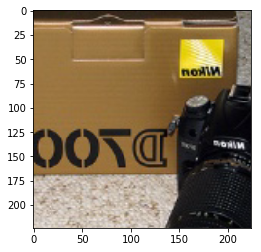

In [31]:
n = 103
import matplotlib.pyplot as plt
from synsets import imagenet_synsets
pipe_out_cpu = pipe_out[0].asCPU()
img_chw = pipe_out_cpu.at(n)
%matplotlib inline
plt.imshow((np.transpose(img_chw, (1,2,0))+128)/255.0)
print(imagenet_synsets[pipe_out[1].at(n)[0]])